In [1]:
# Generative adversarial network on MNIST
# Reference
# https://blog.csdn.net/sparkexpert/article/details/70147409
# https://www.leiphone.com/news/201704/b8w2VNuvTV2CERMP.html

In [2]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import tensorflow as tf

/home/mzx/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Init
## Init
batch_size = 64

z_len = 100
z_noise = tf.placeholder(dtype=tf.float32, shape=[None, z_len], name='z_noise')
y = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='y')
x_data = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='x_data')
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

In [5]:
# Generator
def generator(z_noise, y, keep_prob, namescope='generator'):
    """The generator"""
    with tf.name_scope(namescope):
        net = tf.concat([z_noise, y], axis=1)
        net = tf.layers.dense(net, units=150, activation=tf.nn.relu, name='g_fc1')
        net = tf.nn.dropout(net, keep_prob=keep_prob)
        net = tf.layers.dense(net, units=300, activation=tf.nn.relu, name='g_fc2')
        net = tf.nn.dropout(net, keep_prob=keep_prob)
        net = tf.layers.dense(net, units=784, activation=tf.nn.sigmoid, name='g_fc3')
        # net = tf.nn.dropout(net, keep_prob=keep_prob)
    return net

In [6]:
# descriminator
def discriminator(d_in, y, z_len, keep_prob, namescope='descriminator', reuse=True):
    """The descriminator"""
    with tf.name_scope(namescope):
        net = tf.concat([d_in, y], axis=1)
        net = tf.layers.dense(net, units=300, activation=tf.nn.relu, name='d_fc1', reuse=reuse)
        net = tf.nn.dropout(net, keep_prob=keep_prob)
        net = tf.layers.dense(net, units=150, activation=tf.nn.relu, name='d_fc2', reuse=reuse)
        net = tf.nn.dropout(net, keep_prob=keep_prob)
        # net = tf.layers.dense(net, units=z_len+10, activation=tf.nn.relu, name='d_fc3', reuse=reuse)
        # net = tf.nn.dropout(net, keep_prob=keep_prob)
        net = tf.layers.dense(net, units=1, activation=tf.nn.sigmoid, name='d_fc4', reuse=reuse)
        # net = tf.nn.dropout(net, keep_prob=keep_prob)
        return net

In [7]:
# generate the network
x_g = generator(z_noise, y, keep_prob)
d_g = discriminator(x_g, y, z_len, keep_prob, reuse=False)
d_data = discriminator(x_data, y, z_len, keep_prob)

In [8]:
# get variables
varlist = tf.trainable_variables()
for v in varlist:
    print(v)

<tf.Variable 'g_fc1/kernel:0' shape=(110, 150) dtype=float32_ref>
<tf.Variable 'g_fc1/bias:0' shape=(150,) dtype=float32_ref>
<tf.Variable 'g_fc2/kernel:0' shape=(150, 300) dtype=float32_ref>
<tf.Variable 'g_fc2/bias:0' shape=(300,) dtype=float32_ref>
<tf.Variable 'g_fc3/kernel:0' shape=(300, 784) dtype=float32_ref>
<tf.Variable 'g_fc3/bias:0' shape=(784,) dtype=float32_ref>
<tf.Variable 'd_fc1/kernel:0' shape=(794, 300) dtype=float32_ref>
<tf.Variable 'd_fc1/bias:0' shape=(300,) dtype=float32_ref>
<tf.Variable 'd_fc2/kernel:0' shape=(300, 150) dtype=float32_ref>
<tf.Variable 'd_fc2/bias:0' shape=(150,) dtype=float32_ref>
<tf.Variable 'd_fc4/kernel:0' shape=(150, 1) dtype=float32_ref>
<tf.Variable 'd_fc4/bias:0' shape=(1,) dtype=float32_ref>


In [9]:
# The objective
with tf.name_scope("loss"):
    loss_d = - (tf.reduce_mean(tf.log(1e-8 + d_data)) + tf.reduce_mean(tf.log(1e-8 + 1 - d_g)))
    loss_g = - tf.reduce_mean(tf.log(1e-8 + d_g))
    train_op_g = tf.train.AdamOptimizer(0.0001).minimize(loss_g, var_list=varlist[0:6])
    train_op_d = tf.train.AdamOptimizer(0.0001).minimize(loss_d, var_list=varlist[6:])

In [11]:
# load data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True, validation_size=5000)

Extracting ../../conditional_vae/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../conditional_vae/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../conditional_vae/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../conditional_vae/MNIST_data/t10k-labels-idx1-ubyte.gz


In [12]:
def gen_noise(shape):
    z_noise = np.random.normal(0, 1.0, size=shape).astype(np.float32)
    return z_noise

In [13]:
# Train
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [14]:
import time

def get_timestamp():
    """Get time at present"""
    import time
    timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
    return timestamp

In [15]:
for i in range(50000):
    batch = mnist.train.next_batch(batch_size=batch_size)
    batch_noise = gen_noise(shape=[batch_size, z_len])
    sess.run(train_op_g, feed_dict = {
        z_noise: batch_noise, y: batch[1], keep_prob: 0.5})
    sess.run(train_op_d, feed_dict = {
        z_noise: batch_noise, x_data: batch[0], y: batch[1], keep_prob: 0.5})    

    if not i % 2000:
        batch = mnist.validation.next_batch(batch_size=batch_size)
        ls_g, ls_d  = sess.run(
            [loss_g, loss_d], 
            feed_dict = {
                z_noise: batch_noise, x_data: batch[0], y: batch[1], keep_prob: 1.0})
        
        t = get_timestamp()
        print("[{0}]".format(t), i, ls_g, ls_d)

[2018-04-15: 09:31:28] 0 0.771441 1.3141125
[2018-04-15: 09:31:42] 2000 3.8468866 0.025255667
[2018-04-15: 09:31:55] 4000 6.8892655 0.0014416008
[2018-04-15: 09:32:09] 6000 6.6263914 0.0019878028
[2018-04-15: 09:32:23] 8000 4.951351 0.038987134
[2018-04-15: 09:32:36] 10000 4.7401714 0.06303507
[2018-04-15: 09:32:49] 12000 4.5529804 0.17576161
[2018-04-15: 09:33:04] 14000 3.2073264 0.21201509
[2018-04-15: 09:33:18] 16000 3.4090824 0.15075445
[2018-04-15: 09:33:31] 18000 3.2912583 0.15004832
[2018-04-15: 09:33:44] 20000 2.899675 0.27327132
[2018-04-15: 09:33:58] 22000 3.0113726 0.16175666
[2018-04-15: 09:34:11] 24000 2.7824488 0.16379973
[2018-04-15: 09:34:26] 26000 2.62455 0.28957555
[2018-04-15: 09:34:39] 28000 2.7707605 0.32123122
[2018-04-15: 09:34:52] 30000 2.6615696 0.29371983
[2018-04-15: 09:35:06] 32000 2.3977742 0.3292185
[2018-04-15: 09:35:19] 34000 2.3871336 0.3036455
[2018-04-15: 09:35:33] 36000 2.2811172 0.3873743
[2018-04-15: 09:35:48] 38000 2.3453088 0.27964866
[2018-04-15

/home/mzx/.local/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


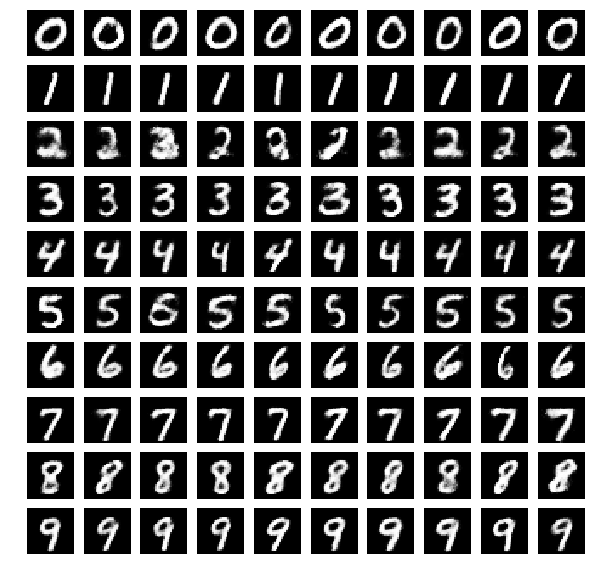

In [16]:
n_examples = 10

fig, axs = plt.subplots(10, n_examples, figsize=(n_examples, 10))
for i in range(10):
    z_gen = gen_noise(shape=[n_examples,z_len])
    # label
    labels = np.zeros([n_examples, 10])
    labels[:,i] = 1
    imgs = sess.run(x_g, feed_dict = {z_noise: z_gen, y: labels, keep_prob: 1.0})
    img_test = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]
    for example_i in range(n_examples):
        # original
        axs[i][example_i].imshow(img_test[example_i], cmap='gray')
        axs[i][example_i].axis('off')

fig.show()
plt.draw()